In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# 학습 모델 저장을 위한 라이브러리
import pickle

# 시간 관련
import time
import shap

In [2]:
import pandas as pd
import numpy as np

# ⬅️ 사용할 전체 컬럼 목록에 비율 계산용 컬럼도 포함시켜 먼저 불러와야 함
file_path = 'data/통합_train_병합완료.parquet'

# ✅ train 데이터 불러오기
train_df = pd.read_parquet(file_path)

In [2]:
def map_categorical_columns(df, verbose=True):
    """
    미리 정의된 매핑 기준에 따라 범주형 컬럼들을 수치형으로 변환합니다.
    처리 컬럼: 거주시도명, 연회비발생카드수_B0M, 한도증액횟수_R12M, 이용금액대,
              할인건수_R3M, 할인건수_B0M, 방문횟수_PC_R6M, 방문횟수_앱_R6M, 방문일수_PC_R6M
    """

    # 1. 거주시도명 → 수도권 여부
    capital_area = ['서울특별시', '경기도', '인천광역시']
    if '거주시도명' in df.columns:
        df['거주시도명'] = df['거주시도명'].apply(lambda x: 1 if x in capital_area else 0)
        if verbose: print("[거주시도명] → 수도권 여부 인코딩 완료")

    # 2. 연회비발생카드수_B0M
    mapping = {"0개": 0, "1개이상": 1}
    if '연회비발생카드수_B0M' in df.columns:
        df['연회비발생카드수_B0M'] = df['연회비발생카드수_B0M'].map(mapping).astype(int)
        if verbose: print("[연회비발생카드수_B0M] 인코딩 완료")

    # 3. 한도증액횟수_R12M
    mapping = {"0회": 0, "1회이상": 1}
    if '한도증액횟수_R12M' in df.columns:
        df['한도증액횟수_R12M'] = df['한도증액횟수_R12M'].map(mapping).astype(int)
        if verbose: print("[한도증액횟수_R12M] 인코딩 완료")

    # 4. 이용금액대 (중간값 기준: 만원 단위)
    mapping = {
        "09.미사용": 0,
        "05.10만원-": 5,
        "04.10만원+": 20,
        "03.30만원+": 40,
        "02.50만원+": 75,
        "01.100만원+": 150
    }
    if '이용금액대' in df.columns:
        df['이용금액대'] = df['이용금액대'].map(mapping)
        if verbose: print("[이용금액대] 중간값 인코딩 완료")

    # 5. 할인건수 인코딩
    discount_map = {
        "1회 이상": 1,
        "10회 이상": 10,
        "20회 이상": 20,
        "30회 이상": 30,
        "40회 이상": 40
    }
    for col in ['할인건수_R3M', '할인건수_B0M']:
        if col in df.columns:
            df[col] = df[col].map(discount_map).astype(int)
            if verbose: print(f"[{col}] 인코딩 완료")

    # 6. 방문횟수 및 방문일수 인코딩
    visit_map = {
        "1회 이상": 1,
        "10회 이상": 10,
        "20회 이상": 20,
        "30회 이상": 30,
        "40회 이상": 40,
        "50회 이상": 50,
        "60회 이상": 60,
        "70회 이상": 70,
        "80회 이상": 80
    }

    visit_cols = ['방문횟수_PC_R6M', '방문횟수_앱_R6M', '방문일수_PC_R6M']
    for col in visit_cols:
        if col in df.columns:
            df[col] = df[col].map(visit_map).astype(int)
            if verbose: print(f"[{col}] 인코딩 완료")

    return df

In [4]:
train_df = map_categorical_columns(train_df)

[거주시도명] → 수도권 여부 인코딩 완료
[연회비발생카드수_B0M] 인코딩 완료
[한도증액횟수_R12M] 인코딩 완료
[이용금액대] 중간값 인코딩 완료
[할인건수_R3M] 인코딩 완료
[할인건수_B0M] 인코딩 완료


In [3]:
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
print(categorical_cols)

NameError: name 'train_df' is not defined

In [6]:
# ✅ 전체 컬럼 수 및 미리보기
print(f"총 컬럼 수: {len(train_df.columns)}개")
print("\n📌 전체 컬럼 목록:")
print(train_df.columns.tolist())

# ✅ 결측치 요약
print("\n🔍 결측치 개수:")
print(train_df.isnull().sum().sort_values(ascending=False))

# ✅ 데이터 타입 요약
print("\n📊 데이터 타입 요약:")
print(train_df.dtypes.value_counts())

총 컬럼 수: 175개

📌 전체 컬럼 목록:
['정상입금원금_B2M', '증감율_이용금액_체크_분기', '할부금액_무이자_3M_R12M', '이용건수_할부_무이자_R12M', '증감율_이용건수_체크_전월', '청구금액_R6M', '홈페이지_금융건수_R6M', '이용건수_A페이_R6M', '포인트_포인트_월적립_B0M', '제휴연회비_B0M', '증감율_이용건수_할부_전월', 'RV현금서비스이자율_할인전', '상향가능CA한도금액', '컨택건수_신용발급_TM_R6M', '연속유실적개월수_기본_24M_카드', '컨택건수_이용유도_청구서_B0M', '이용금액_일시불_R6M', '방문일수_앱_B0M', '승인거절건수_입력오류_R3M', '교통_주유이용금액', 'RP건수_보험_B0M', '증감율_이용건수_신판_분기', '증감율_이용금액_일시불_전월', '잔액_할부_B0M', '컨택건수_이용유도_TM_R6M', '포인트_마일리지_환산_B0M', '이용여부_3M_해외겸용_본인', '기본연회비_B0M', 'CA한도금액', '청구서발송여부_R6M', 'RP후경과월', '연체잔액_RV일시불_B0M', '방문일수_앱_R6M', '탈회횟수_발급1년이내', '최대이용금액_일시불_R12M', '변동률_RVCA평잔', '쇼핑_마트_이용금액', '마일_적립포인트_R3M', '최초한도금액', '컨택건수_이용유도_EM_B0M', '이용건수_C페이_R6M', '인입일수_ARS_B0M', '컨택건수_이용유도_EM_R6M', 'RP건수_통신_B0M', '연체감액여부_R3M', '이용후경과월_체크', '유효카드수_신용체크', '정상청구원금_B5M', '증감율_이용금액_신용_전월', '이용가맹점수', '포인트_포인트_건별_B0M', '컨택건수_이용유도_인터넷_R6M', '평잔_6M', '잔액_신판ca최대한도소진율_r6m', '마일_잔여포인트_B0M', '승인거절건수_한도초과_R3M', '당사멤버쉽_방문횟수_R6M', '이용금액_할부_무이자_R6M', '이용금액_R3M_신용', '정상청구원금_B0M',

In [7]:
# 📌 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

# 📌 1. 데이터 전처리
X = train_df.drop(columns=["ID", "Segment"]).copy()
y = train_df["Segment"]

# 범주형 인코딩
cat_cols = X.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 스케일링
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 타겟 인코딩
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 📌 2. Optuna로 하이퍼파라미터 튜닝 (3-Fold 교차검증 기준)
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 180, 350),
        'max_depth': trial.suggest_int('max_depth', 7, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'random_state': 42
    }

    model = XGBClassifier(**params)

    # 간단한 평가 (K-Fold 없이 전체에서 cross_val)
    score = cross_val_score(model, X_scaled, y_encoded, cv=3, scoring='f1_weighted')
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # ✅ 컴퓨터 리소스 고려해서 20회만

# 최적 파라미터 확인
best_params = study.best_params
print("\n✅ 최적 하이퍼파라미터:")
for k, v in best_params.items():
    print(f"{k}: {v}")

[I 2025-07-11 23:46:27,003] A new study created in memory with name: no-name-c74db3dc-ac57-4e87-8e8e-a79e9c4af105
[I 2025-07-11 23:53:13,759] Trial 0 finished with value: 0.9169614762612834 and parameters: {'n_estimators': 208, 'max_depth': 10, 'learning_rate': 0.07133176422516443, 'subsample': 0.9893441277486763, 'colsample_bytree': 0.7914356114949607}. Best is trial 0 with value: 0.9169614762612834.
[I 2025-07-12 00:00:03,010] Trial 1 finished with value: 0.9124525152584857 and parameters: {'n_estimators': 247, 'max_depth': 9, 'learning_rate': 0.06288169465395418, 'subsample': 0.80840452493386, 'colsample_bytree': 0.6457576691833828}. Best is trial 0 with value: 0.9169614762612834.
[I 2025-07-12 00:05:49,863] Trial 2 finished with value: 0.9098349565844481 and parameters: {'n_estimators': 224, 'max_depth': 8, 'learning_rate': 0.08746167411729476, 'subsample': 0.8561762000706681, 'colsample_bytree': 0.6008668321395524}. Best is trial 0 with value: 0.9169614762612834.
[I 2025-07-12 00:


✅ 최적 하이퍼파라미터:
n_estimators: 350
max_depth: 10
learning_rate: 0.09734117678318878
subsample: 0.9096667798500799
colsample_bytree: 0.9375641079621172


In [8]:
# 📌 3. K-Fold 학습 (튜닝된 파라미터로)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ros = RandomOverSampler(sampling_strategy={0: 2000, 1: 2000}, random_state=42)

fold = 1
all_reports = []

for train_idx, val_idx in skf.split(X_scaled, y_encoded):
    X_train, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    X_train_os, y_train_os = ros.fit_resample(X_train, y_train)
    print(f"\n🔁 Fold {fold} 오버샘플링 완료:", pd.Series(y_train_os).value_counts().to_dict())

    # 튜닝된 파라미터 + 고정 파라미터 구성
    xgb_model = XGBClassifier(
        **best_params,
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

    xgb_model.fit(X_train_os, y_train_os)
    y_pred = xgb_model.predict(X_val)

    print(f"\n📘 Fold {fold} 결과")
    print(classification_report(y_val, y_pred, target_names=le_y.classes_))

    all_reports.append(classification_report(y_val, y_pred, output_dict=True))
    fold += 1


🔁 Fold 1 오버샘플링 완료: {4: 1537642, 3: 279393, 2: 102072, 0: 2000, 1: 2000}

📘 Fold 1 결과
              precision    recall  f1-score   support

           A       0.97      0.71      0.82       195
           B       1.00      0.61      0.76        28
           C       0.87      0.76      0.81     25518
           D       0.83      0.79      0.81     69849
           E       0.96      0.98      0.97    384410

    accuracy                           0.94    480000
   macro avg       0.93      0.77      0.83    480000
weighted avg       0.94      0.94      0.94    480000


🔁 Fold 2 오버샘플링 완료: {4: 1537642, 3: 279393, 2: 102072, 0: 2000, 1: 2000}

📘 Fold 2 결과
              precision    recall  f1-score   support

           A       0.97      0.74      0.84       194
           B       1.00      0.62      0.77        29
           C       0.86      0.76      0.81     25518
           D       0.83      0.79      0.81     69849
           E       0.96      0.98      0.97    384410

    accuracy 

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 결측치 처리기
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)  # 학습 데이터로 fit 해야 함

# 스케일러
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

#### 최적의 쓰레스값 찾기

### 옵튜나 사용

In [10]:
import optuna
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 확률 예측 (없을 경우 추가)
# X_val과 xgb_model, y_val이 이미 있어야 함
y_val_proba = xgb_model.predict_proba(X_val)

# ✅ 결과 저장 리스트
best_thresholds = []
best_f1s = []

# ✅ 클래스 수 자동 감지
n_classes = y_val_proba.shape[1]

# ✅ 클래스별로 반복 실행
for class_idx in range(n_classes):
    print(f"🔍 클래스 {class_idx} 최적 threshold 탐색 중...")

    target_class = class_idx  # 외부에서 objective 함수가 참조함

    def objective(trial):
        threshold = trial.suggest_float("threshold", 0.1, 0.9)
        y_pred = []
        for row in y_val_proba:
            if row[target_class] >= threshold:
                y_pred.append(target_class)
            else:
                y_pred.append(np.argmax(row))
        return f1_score(y_val, y_pred, average='weighted')

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=50)

    best_thresh = study.best_params["threshold"]
    best_f1 = study.best_value

    best_thresholds.append(best_thresh)
    best_f1s.append(best_f1)

    print(f"✅ Class {class_idx}: Threshold = {best_thresh:.2f}, F1 = {best_f1:.4f}")

# ✅ 최종 확인
print("\n🎯 클래스별 Best Threshold 리스트:")
for idx, t in enumerate(best_thresholds):
    print(f"  Class {idx}: {t:.2f}")

[I 2025-07-12 07:40:03,770] A new study created in memory with name: no-name-18321808-c136-46f9-896c-3c4d118663b1


🔍 클래스 0 최적 threshold 탐색 중...


[I 2025-07-12 07:40:05,251] Trial 0 finished with value: 0.9402046073297274 and parameters: {'threshold': 0.39963209507789}. Best is trial 0 with value: 0.9402046073297274.
[I 2025-07-12 07:40:06,684] Trial 1 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.8605714451279329}. Best is trial 0 with value: 0.9402046073297274.
[I 2025-07-12 07:40:08,122] Trial 2 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.685595153449124}. Best is trial 0 with value: 0.9402046073297274.
[I 2025-07-12 07:40:09,588] Trial 3 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.5789267873576293}. Best is trial 0 with value: 0.9402046073297274.
[I 2025-07-12 07:40:11,028] Trial 4 finished with value: 0.9402370983897056 and parameters: {'threshold': 0.22481491235394924}. Best is trial 4 with value: 0.9402370983897056.
[I 2025-07-12 07:40:12,481] Trial 5 finished with value: 0.9402370983897056 and parameters: {'threshold': 0.22479561626896213}.

✅ Class 0: Threshold = 0.19, F1 = 0.9402
🔍 클래스 1 최적 threshold 탐색 중...


[I 2025-07-12 07:41:17,510] Trial 0 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.39963209507789}. Best is trial 0 with value: 0.9402045545701689.
[I 2025-07-12 07:41:18,945] Trial 1 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.8605714451279329}. Best is trial 0 with value: 0.9402045545701689.
[I 2025-07-12 07:41:20,372] Trial 2 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.685595153449124}. Best is trial 0 with value: 0.9402045545701689.
[I 2025-07-12 07:41:21,823] Trial 3 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.5789267873576293}. Best is trial 0 with value: 0.9402045545701689.
[I 2025-07-12 07:41:23,254] Trial 4 finished with value: 0.9402021996634037 and parameters: {'threshold': 0.22481491235394924}. Best is trial 0 with value: 0.9402045545701689.
[I 2025-07-12 07:41:24,767] Trial 5 finished with value: 0.9402021996634037 and parameters: {'threshold': 0.22479561626896213}.

✅ Class 1: Threshold = 0.40, F1 = 0.9402
🔍 클래스 2 최적 threshold 탐색 중...


[I 2025-07-12 07:42:29,670] Trial 0 finished with value: 0.9401801144574661 and parameters: {'threshold': 0.39963209507789}. Best is trial 0 with value: 0.9401801144574661.
[I 2025-07-12 07:42:31,090] Trial 1 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.8605714451279329}. Best is trial 1 with value: 0.9402045545701689.
[I 2025-07-12 07:42:32,506] Trial 2 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.685595153449124}. Best is trial 1 with value: 0.9402045545701689.
[I 2025-07-12 07:42:33,935] Trial 3 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.5789267873576293}. Best is trial 1 with value: 0.9402045545701689.
[I 2025-07-12 07:42:35,326] Trial 4 finished with value: 0.9371288319287449 and parameters: {'threshold': 0.22481491235394924}. Best is trial 1 with value: 0.9402045545701689.
[I 2025-07-12 07:42:36,730] Trial 5 finished with value: 0.9371288319287449 and parameters: {'threshold': 0.22479561626896213}.

✅ Class 2: Threshold = 0.86, F1 = 0.9402
🔍 클래스 3 최적 threshold 탐색 중...


[I 2025-07-12 07:43:40,592] Trial 0 finished with value: 0.9405997987105775 and parameters: {'threshold': 0.39963209507789}. Best is trial 0 with value: 0.9405997987105775.
[I 2025-07-12 07:43:42,009] Trial 1 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.8605714451279329}. Best is trial 0 with value: 0.9405997987105775.
[I 2025-07-12 07:43:43,379] Trial 2 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.685595153449124}. Best is trial 0 with value: 0.9405997987105775.
[I 2025-07-12 07:43:44,742] Trial 3 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.5789267873576293}. Best is trial 0 with value: 0.9405997987105775.
[I 2025-07-12 07:43:46,092] Trial 4 finished with value: 0.9261227286857233 and parameters: {'threshold': 0.22481491235394924}. Best is trial 0 with value: 0.9405997987105775.
[I 2025-07-12 07:43:47,425] Trial 5 finished with value: 0.9261176414579574 and parameters: {'threshold': 0.22479561626896213}.

✅ Class 3: Threshold = 0.43, F1 = 0.9410
🔍 클래스 4 최적 threshold 탐색 중...


[I 2025-07-12 07:44:48,359] Trial 0 finished with value: 0.9364449145706779 and parameters: {'threshold': 0.39963209507789}. Best is trial 0 with value: 0.9364449145706779.
[I 2025-07-12 07:44:49,330] Trial 1 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.8605714451279329}. Best is trial 1 with value: 0.9402045545701689.
[I 2025-07-12 07:44:50,288] Trial 2 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.685595153449124}. Best is trial 1 with value: 0.9402045545701689.
[I 2025-07-12 07:44:51,257] Trial 3 finished with value: 0.9402045545701689 and parameters: {'threshold': 0.5789267873576293}. Best is trial 1 with value: 0.9402045545701689.
[I 2025-07-12 07:44:52,148] Trial 4 finished with value: 0.9189410728068801 and parameters: {'threshold': 0.22481491235394924}. Best is trial 1 with value: 0.9402045545701689.
[I 2025-07-12 07:44:53,057] Trial 5 finished with value: 0.9189410728068801 and parameters: {'threshold': 0.22479561626896213}.

✅ Class 4: Threshold = 0.86, F1 = 0.9402

🎯 클래스별 Best Threshold 리스트:
  Class 0: 0.19
  Class 1: 0.40
  Class 2: 0.86
  Class 3: 0.43
  Class 4: 0.86


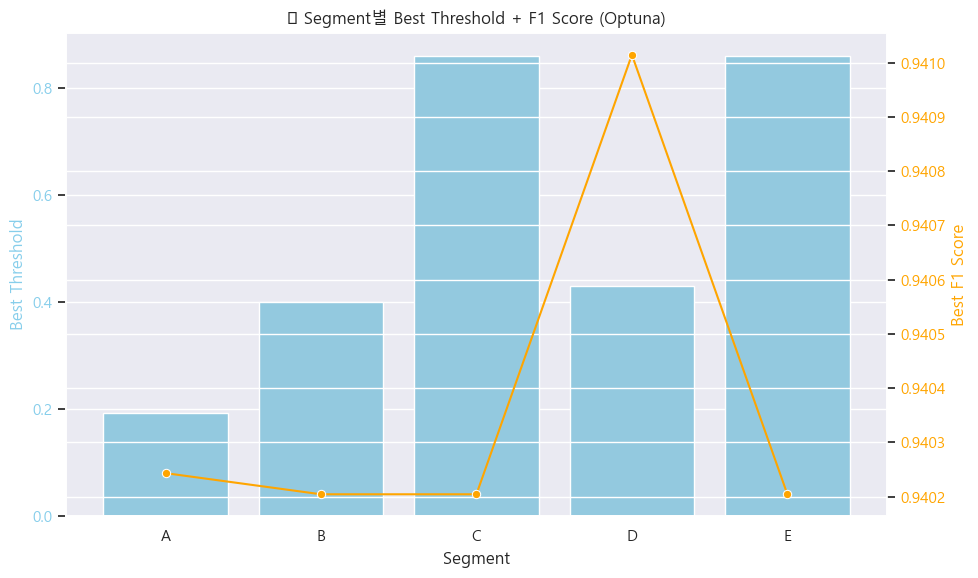

In [11]:
# ✅ 결과 시각화
df_thresh = pd.DataFrame({
    "Segment": le_y.inverse_transform(list(range(n_classes))),
    "Best_Threshold": best_thresholds,
    "Best_F1": best_f1s
})

fig, ax1 = plt.subplots(figsize=(10, 6))

# Threshold 막대
sns.barplot(data=df_thresh, x="Segment", y="Best_Threshold", color="skyblue", ax=ax1)
ax1.set_ylabel("Best Threshold", color="skyblue")
ax1.tick_params(axis='y', labelcolor="skyblue")

# F1 선 그래프 추가
ax2 = ax1.twinx()
sns.lineplot(data=df_thresh, x="Segment", y="Best_F1", color="orange", marker="o", ax=ax2)
ax2.set_ylabel("Best F1 Score", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")

plt.title("Segment별 Best Threshold + F1 Score (Optuna)")
plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import classification_report

# ✅ 먼저 threshold 기반 예측 함수 정의
def predict_with_thresholds(y_proba, thresholds, exclude_from_fallback=None):
    preds = []
    for row in y_proba:
        candidates = [i for i, p in enumerate(row) if p >= thresholds[i]]
        if candidates:
            preds.append(candidates[np.argmax([row[i] for i in candidates])])
        else:
            row_copy = row.copy()
            if exclude_from_fallback is not None:
                for idx in exclude_from_fallback:
                    row_copy[idx] = -1
            preds.append(np.argmax(row_copy))
    return np.array(preds)

# ✅ threshold 적용 예측
y_val_pred_encoded = predict_with_thresholds(y_val_proba, best_thresholds)
y_val_pred = le_y.inverse_transform(y_val_pred_encoded)
y_val_true = le_y.inverse_transform(y_val)

# ✅ classification report 출력
print("\n📊 Classification Report (Best Threshold 적용):")
print(classification_report(y_val_true, y_val_pred, target_names=le_y.classes_))


📊 Classification Report (Best Threshold 적용):
              precision    recall  f1-score   support

           A       0.90      0.86      0.88       195
           B       1.00      0.79      0.88        29
           C       0.88      0.74      0.80     25518
           D       0.81      0.82      0.82     69848
           E       0.97      0.98      0.97    384410

    accuracy                           0.94    480000
   macro avg       0.91      0.84      0.87    480000
weighted avg       0.94      0.94      0.94    480000



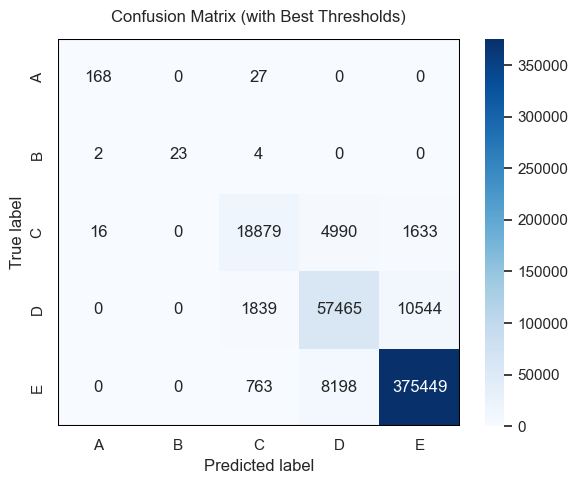

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 생성
cm = confusion_matrix(y_val_true, y_val_pred, labels=le_y.classes_)

# 시각화
plt.figure(figsize=(6, 5))
sns.set(style="white")

# heatmap 그리기 (테두리는 없음)
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le_y.classes_,
    yticklabels=le_y.classes_,
    cbar=True,
    linewidths=0,        # 셀 내부 테두리는 없음
    linecolor='white'    # 셀 내부 테두리 색
)

# ✅ 바깥 테두리 추가
# (0,0)을 기준으로 왼쪽 위 꼭짓점부터 시작해서 총 height, width를 덮는 테두리
ax.add_patch(plt.Rectangle(
    (0, 0),                # 왼쪽 아래 좌표
    cm.shape[1],           # 너비 (열 개수)
    cm.shape[0],           # 높이 (행 개수)
    fill=False,
    edgecolor='black',     # 검정 테두리
    lw=1.5                 # 얇은 선 두께
))

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (with Best Thresholds)", pad=12)
plt.tight_layout()
plt.show()

In [4]:
from sklearn.exceptions import NotFittedError

try:
    xgb_model.predict(X_scaled[:5])
    print("✅ 모델이 학습되어 있습니다.")
except NotFittedError:
    print("❌ 모델이 아직 학습되지 않았습니다.")


NameError: name 'xgb_model' is not defined

In [15]:
from collections import Counter
print(Counter(y_encoded))

Counter({4: 1922052, 3: 349242, 2: 127590, 0: 972, 1: 144})


In [16]:
import joblib

# ✅ 모델 및 전처리기 저장
joblib.dump(xgb_model, "models/xgb_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(imputer, "models/imputer.pkl")
joblib.dump(le_y, "models/le_y.pkl")
joblib.dump(best_thresholds, "models/best_thresholds.pkl")  # 👈 추가

print("✅ 모델, 전처리기 및 최적 threshold 저장 완료 (models 폴더)")

✅ 모델, 전처리기 및 최적 threshold 저장 완료 (models 폴더)


In [6]:
import joblib
# ✅ 1. 저장된 객체 로드
xgb_model = joblib.load("models/xgb_model.pkl")
scaler    = joblib.load("models/scaler.pkl")
le_y      = joblib.load("models/le_y.pkl")
imputer      = joblib.load("models/imputer.pkl")
best_thresholds = joblib.load("models/best_thresholds.pkl")

In [7]:
imputer.feature_names_in_

array(['정상입금원금_B2M', '증감율_이용금액_체크_분기', '할부금액_무이자_3M_R12M',
       '이용건수_할부_무이자_R12M', '증감율_이용건수_체크_전월', '청구금액_R6M', '홈페이지_금융건수_R6M',
       '이용건수_A페이_R6M', '포인트_포인트_월적립_B0M', '제휴연회비_B0M', '증감율_이용건수_할부_전월',
       'RV현금서비스이자율_할인전', '상향가능CA한도금액', '컨택건수_신용발급_TM_R6M',
       '연속유실적개월수_기본_24M_카드', '컨택건수_이용유도_청구서_B0M', '이용금액_일시불_R6M',
       '방문일수_앱_B0M', '승인거절건수_입력오류_R3M', '교통_주유이용금액', 'RP건수_보험_B0M',
       '증감율_이용건수_신판_분기', '증감율_이용금액_일시불_전월', '잔액_할부_B0M',
       '컨택건수_이용유도_TM_R6M', '포인트_마일리지_환산_B0M', '이용여부_3M_해외겸용_본인',
       '기본연회비_B0M', 'CA한도금액', '청구서발송여부_R6M', 'RP후경과월', '연체잔액_RV일시불_B0M',
       '방문일수_앱_R6M', '탈회횟수_발급1년이내', '최대이용금액_일시불_R12M', '변동률_RVCA평잔',
       '쇼핑_마트_이용금액', '마일_적립포인트_R3M', '최초한도금액', '컨택건수_이용유도_EM_B0M',
       '이용건수_C페이_R6M', '인입일수_ARS_B0M', '컨택건수_이용유도_EM_R6M', 'RP건수_통신_B0M',
       '연체감액여부_R3M', '이용후경과월_체크', '유효카드수_신용체크', '정상청구원금_B5M',
       '증감율_이용금액_신용_전월', '이용가맹점수', '포인트_포인트_건별_B0M', '컨택건수_이용유도_인터넷_R6M',
       '평잔_6M', '잔액_신판ca최대한도소진율_r6m', '마일_잔여포인트_B0M', '승인거절건

In [19]:
import pandas as pd

# ✅ 병합 완료된 테스트 데이터 불러오기
test_df = pd.read_parquet("data/통합_test_병합완료.parquet")

# ✅ 전체 컬럼 수 및 미리보기
print(f"📌 총 컬럼 수: {len(test_df.columns)}개")
print("\n🧾 전체 컬럼 목록:")
print(test_df.columns.tolist())

# ✅ 결측치 개수 확인
print("\n🔍 결측치 개수:")
print(test_df.isnull().sum().sort_values(ascending=False))

# ✅ 데이터 타입 요약
print("\n📊 데이터 타입 요약:")
print(test_df.dtypes.value_counts())

# ✅ 상위 5개 행 확인 (선택)
print("\n🧪 상위 5개 데이터 미리보기:")
print(test_df.head())

📌 총 컬럼 수: 174개

🧾 전체 컬럼 목록:
['정상입금원금_B2M', '증감율_이용금액_체크_분기', '할부금액_무이자_3M_R12M', '이용건수_할부_무이자_R12M', '증감율_이용건수_체크_전월', '청구금액_R6M', '홈페이지_금융건수_R6M', '이용건수_A페이_R6M', '포인트_포인트_월적립_B0M', '제휴연회비_B0M', '증감율_이용건수_할부_전월', 'RV현금서비스이자율_할인전', '상향가능CA한도금액', '컨택건수_신용발급_TM_R6M', '연속유실적개월수_기본_24M_카드', '컨택건수_이용유도_청구서_B0M', '이용금액_일시불_R6M', '방문일수_앱_B0M', '승인거절건수_입력오류_R3M', '교통_주유이용금액', 'RP건수_보험_B0M', '증감율_이용건수_신판_분기', '증감율_이용금액_일시불_전월', '잔액_할부_B0M', '컨택건수_이용유도_TM_R6M', '포인트_마일리지_환산_B0M', '이용여부_3M_해외겸용_본인', '기본연회비_B0M', 'CA한도금액', '청구서발송여부_R6M', 'RP후경과월', '연체잔액_RV일시불_B0M', '방문일수_앱_R6M', '탈회횟수_발급1년이내', '최대이용금액_일시불_R12M', '변동률_RVCA평잔', '쇼핑_마트_이용금액', '마일_적립포인트_R3M', '최초한도금액', '컨택건수_이용유도_EM_B0M', '이용건수_C페이_R6M', '인입일수_ARS_B0M', '컨택건수_이용유도_EM_R6M', 'RP건수_통신_B0M', '연체감액여부_R3M', '이용후경과월_체크', '유효카드수_신용체크', '정상청구원금_B5M', '증감율_이용금액_신용_전월', '이용가맹점수', '포인트_포인트_건별_B0M', '컨택건수_이용유도_인터넷_R6M', '평잔_6M', '잔액_신판ca최대한도소진율_r6m', '마일_잔여포인트_B0M', '승인거절건수_한도초과_R3M', '당사멤버쉽_방문횟수_R6M', '이용금액_할부_무이자_R6M', '이용금액_R3M_신용', '정상청구원금_B0M

In [8]:
from datetime import datetime


# ✅ 2. 테스트 데이터 불러오기 (병합 및 전처리된 상태라고 가정)
test_df = pd.read_parquet("data/통합_test_병합완료.parquet")

# ✅ 3. 피처 선택
all_features = list(imputer.feature_names_in_)  # 학습 시 사용한 피처 순서 그대로
# 입력 데이터 구성
X_test = test_df[all_features].copy()

# ✅ 4. 범주형 인코딩 (1차: 사용자 정의 함수)
X_test = map_categorical_columns(X_test, verbose=False)

# ✅ 4-1. 남은 object 컬럼이 있다면 추가 인코딩
remaining_obj_cols = X_test.select_dtypes(include='object').columns.tolist()
if remaining_obj_cols:
    print(f"🚨 추가 인코딩 대상 컬럼: {remaining_obj_cols}")
    for col in remaining_obj_cols:
        le = LabelEncoder()
        X_test[col] = le.fit_transform(X_test[col].astype(str))


# ✅ 5. 결측치 처리 및 스케일링
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
X_test_scaled = scaler.transform(X_test)

# ✅ 6. 예측 확률 계산
y_test_proba = xgb_model.predict_proba(X_test_scaled)

# ✅ 7. Threshold 기반 예측 함수
def predict_with_thresholds(y_proba, thresholds, exclude_from_fallback=None):
    preds = []
    for row in y_proba:
        candidates = [i for i, p in enumerate(row) if p >= thresholds[i]]
        if candidates:
            preds.append(candidates[np.argmax([row[i] for i in candidates])])
        else:
            row_copy = row.copy()
            if exclude_from_fallback is not None:
                for idx in exclude_from_fallback:
                    row_copy[idx] = -1
            preds.append(np.argmax(row_copy))
    return np.array(preds)

# ✅ 8. Threshold 적용 예측
a_index = le_y.transform(['A'])[0]

y_test_pred_encoded = predict_with_thresholds(
    y_test_proba, best_thresholds, exclude_from_fallback=[a_index]
)
y_test_pred = le_y.inverse_transform(y_test_pred_encoded)

# ✅ 9. 결과 저장
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'Segment': y_test_pred
})
submission = submission.drop_duplicates(subset='ID', keep='first')

today = datetime.now().strftime('%Y%m%d')
submission.to_csv(f"submission_{today}.csv", index=False)
print(f"✅ 예측 완료 및 저장: submission_{today}.csv")

✅ 예측 완료 및 저장: submission_20250712.csv


In [9]:
import pandas as pd

# 예측 결과를 Series로 변환
y_series = pd.Series(y_test_pred, name="Segment")

# 분포 확인 (클래스별 건수 + 비율)
print("📊 예측된 Segment 분포:")
print(y_series.value_counts().sort_index())      # 클래스별 개수
print("\n📈 비율 (%):")
print((y_series.value_counts(normalize=True).sort_index() * 100).round(2))

📊 예측된 Segment 분포:
Segment
A       151
B         5
C     25496
D     87604
E    486744
Name: count, dtype: int64

📈 비율 (%):
Segment
A     0.03
B     0.00
C     4.25
D    14.60
E    81.12
Name: proportion, dtype: float64


In [18]:
# ✅ 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Mac은 'AppleGothic'
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 13
plt.rcParams['axes.unicode_minus'] = False

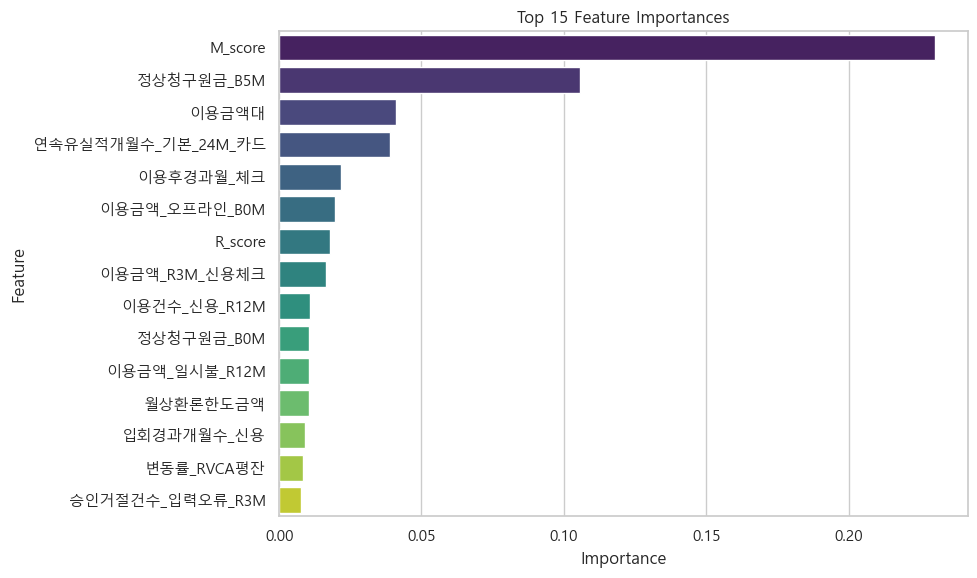

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ 기본 설정
plt.rcParams.update({
    'font.family': 'Malgun Gothic',  # 또는 'AppleGothic'
    'font.size': 14,
    'axes.unicode_minus': False
})

# ✅ 중요도 정리
feature_names = imputer.feature_names_in_  # 또는 all_features
importances = xgb_model.feature_importances_

importance_df = (
    pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    .sort_values(by="Importance", ascending=False)
)

# ✅ 시각화
plt.figure(figsize=(10, 6))  # 위 코드 스타일로 사이즈 맞춤
sns.barplot(data=importance_df.head(15), x="Importance", y="Feature", palette="viridis")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

| 기준         | 의미 설명                                     |
| ---------- | ----------------------------------------- |
| **weight** | 피처가 트리에서 split에 사용된 횟수 (기본값)              |
| **gain**   | 해당 피처로 split했을 때의 평균 손실 감소량 → 가장 해석적으로 중요 |
| **cover**  | 해당 피처로 split된 샘플들의 평균 커버리지 (샘플 수 기반)      |
